In [135]:
import pandas as pd
import wget
import numpy as np
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.pyplot as plt

In [136]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.max_cols', None)

## loading DeepARG results

In [137]:
arg=pd.read_csv("uhgp_deep.out.mapping.ARG",sep="\t")
#create col Genome based on sequence id
arg["Genome"]="GUT_"+arg["read_id"].str.split("_",expand=True)[1]

In [138]:
#arg.groupby("predicted_ARG-class").count()

In [139]:
len(arg)

2579266

## loading CARD database metadata

In [140]:
card=pd.read_csv("aro_index.tsv",sep="\t")
card=card[["Model Name","AMR Gene Family","Protein Accession","Drug Class","Resistance Mechanism"]]
card.rename(columns={"Model Name":"#ARG"},inplace=True)
card["#ARG"]=card["#ARG"].str.upper()
# Merge CARD and deepARG results
arg=pd.merge(arg,card,on="#ARG",how="left")

In [141]:
arg_no_card=arg[arg["Drug Class"].isna()==True]

In [142]:
arg_no_card.drop(["AMR Gene Family","Drug Class","Resistance Mechanism","Protein Accession"],axis=1,inplace=True)

/home/rcuadrat/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [143]:
arg_no_card.head()

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,alignment-evalue,counts,Genome
1,RPOB2,28,1123,GUT_GENOME117977_00047,multidrug,BAD59497.1|FEATURES|rpoB2|multidrug|rpoB2,0.978036,44.7,1410,1050.0,5.700000e-307,1,GUT_GENOME117977
3,MULTIDRUG_ABC_TRANSPORTER,96,577,GUT_GENOME095776_00939,multidrug,gi:686302687:ref:WP_031866869.1:|FEATURES|multidrug_ABC_transporter|multidrug|multidrug_ABC_transporter,0.985329,35.8,497,271.2,7.300000e-73,1,GUT_GENOME095776
4,RPOB2,28,1136,GUT_GENOME040331_00108,multidrug,BAD59497.1|FEATURES|rpoB2|multidrug|rpoB2,0.989358,52.5,1220,1241.9,0.000000e+00,1,GUT_GENOME040331
5,LLMA_23S_RIBOSOMAL_RNA_METHYLTRANSFERASE,1,286,GUT_GENOME208882_00778,MLS,APB03216.1|FEATURES|LlmA_23S_ribosomal_RNA_methyltransferase|MLS|LlmA_23S_ribosomal_RNA_methyltransferase,0.999179,56.3,286,345.1,1.900000e-95,1,GUT_GENOME208882
6,TET35,40,356,GUT_GENOME221189_00155,tetracycline,AF353562.gene.p01|FEATURES|tet35|tetracycline|tet35,0.912911,36.3,380,166.4,1.600000e-41,1,GUT_GENOME221189


In [144]:
arg_no_card["Protein Accession"]=arg_no_card["best-hit"].str.split("|",expand=True)[0]

/home/rcuadrat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [145]:
arg_no_card = pd.merge(arg_no_card,card,on="Protein Accession")

In [146]:
len(arg_no_card)

136000

## loading UHGP metadata

In [147]:
meta=pd.read_csv("../gut_MG/TGoris/Full_DB/genomes_metadata-1.tsv",sep="\t")
meta=meta[["Genome","Lineage","Country","Continent",'Genome_accession', 'Sample_accession','Study_accession','Species_rep',"MGnify_accession","FTP_download"]]

/home/rcuadrat/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [148]:
# Merge UGHP metadata with deepARG + CARD metadata
arg=pd.merge(arg,meta,on="Genome")

## Selecting only MCR genes

In [149]:
MCR=arg[arg["#ARG"].str.contains("MCR-")]
MCR.rename(columns={"read_id":"ptn_id"},inplace=True)


/home/rcuadrat/.local/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [150]:
mcr_samples=MCR["Sample_accession"].drop_duplicates()

In [151]:
MCR.groupby("#ARG").count()["ptn_id"]

#ARG
MCR-1       13
MCR-1.2      1
MCR-2        9
MCR-3      634
MCR-4      456
MCR-5      966
Name: ptn_id, dtype: int64

## Downloading MAGs/genomes with MCR GFF files 

In [152]:
!mkdir -p MAGs_MCR

In [153]:
#had to fix links due to changes in the EBI link
downloads=MCR["FTP_download"].drop_duplicates().str.replace("2019_09","v1.0").to_list()

In [154]:
# for g in downloads:
#     wget.download(g,"MAGs_MCR")

## Bash for split gff and fasta from the gff3 obtained

In [155]:
# !gunzip MAGs_MCR/*
# for f in ${ls MAGs_MCR/*.gff}; do 

# csplit --quiet --prefix=${f%.gff} $f "/##FASTA/" "{*}"

# done 

# cat MAGs_MCR/


# for f in $(ls *.txt); do mv $f ${f%0000.txt}.gff; done

# cat *.gff > all.gff

## Open the gff and work with it

In [156]:
all_gff=pd.read_csv("MAGs_MCR/all.gff",sep="\t",comment="#",header=None)
all_gff["ptn_id"]=all_gff[8].str.split(";",expand=True)[0].str.replace("ID=","")
all_gff=all_gff[[0,3,4,6,8,"ptn_id"]]

## merge mcr table with gff

In [157]:
mcr2=pd.merge(MCR,all_gff,on="ptn_id")
mcr2.rename(columns={0:"contig_id",3:"ptn_start",4:"ptn_stop",6:"ptn_strand",8:"gff_features"},inplace=True)
mcr2["species"]=mcr2["Lineage"].str.split(";",expand=True)[6]
mcr2["genus"]=mcr2["Lineage"].str.split(";",expand=True)[5]
mcr2["family"]=mcr2["Lineage"].str.split(";",expand=True)[4]
mcr2["order"]=mcr2["Lineage"].str.split(";",expand=True)[3]
mcr2.to_csv("mcr_mags.tsv",sep="\t",index=None)
mcr2["genus"]=mcr2["genus"].str.replace("g__","")

## MCR prevalance table and plot x genus

In [158]:
mcr_prevalence=mcr2.groupby(["genus","#ARG"])["#ARG"].count()
mcr_prevalence=pd.DataFrame(mcr_prevalence)
mcr_prevalence.columns=["Number of contigs"]
mcr_prevalence.reset_index(inplace=True)
mcr_prevalence.columns=["Number of #ARGs","plasmid","Number of contigs"]
mcr_prevalence=mcr_prevalence.set_index("Number of #ARGs").pivot(columns="plasmid",values="Number of contigs").fillna("0").reset_index()
mcr_prevalence.index.name = None
mcr_prevalence.columns.names = [None]
mcr_prevalence.set_index("Number of #ARGs",inplace=True)
mcr_prevalence=mcr_prevalence.astype(int)
mcr_prevalence.sort_values("MCR-5",ascending=False,inplace=True)

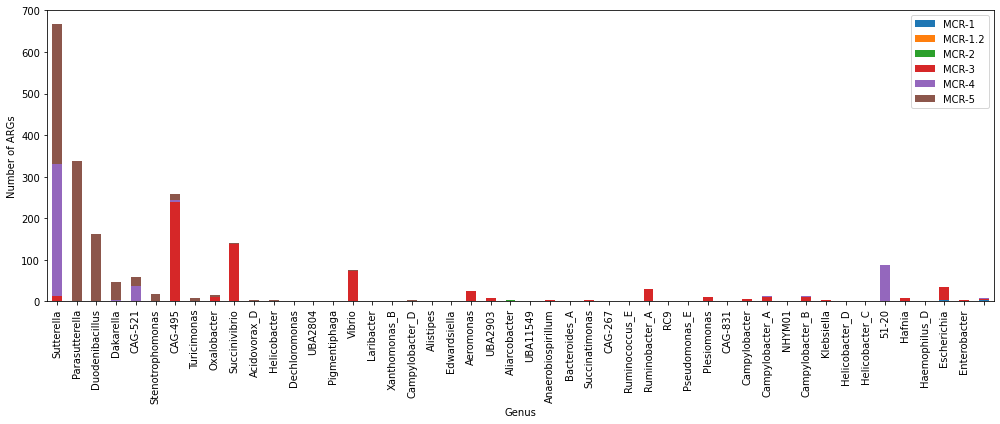

In [159]:
mcr_prevalence.plot(kind="bar",stacked=True,figsize=(14,6))
plt.ylabel("Number of ARGs")
plt.xlabel("Genus")
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

## Generate list of contigs with MCR genes

In [160]:
contigs=mcr2["contig_id"].drop_duplicates()
contigs.to_csv("contigs_mcr.list",index=None,header=None)

## Extract the fasta sequences (NT) for all contigs with MCR

In [161]:
# !cat MAGs_MCR/fasta/*.fasta > MAGs_MCR/fasta/all.fasta
#!xargs samtools faidx MAGs_MCR/fasta/all.fasta < contigs_mcr.list > mcr_contigs.fasta
# Run plasflow

## open PlasFlow results and shape it for merging with mcr table

In [162]:
plas=pd.read_csv("MAGs_MCR/fasta/mcr_contigs.plasflow",sep="\t")
plas.drop(["Unnamed: 0","contig_id"],axis=1,inplace=True)
plas=plas[["contig_name","contig_length","label"]]
plas['plasmid'] = np.where(plas['label'].str.contains("plasmid")==True, 'yes', 'no')
plas["Plasflow_phyla"]=plas["label"].str.split(".",expand=True)[1]
plas.rename(columns={"contig_name":"contig_id"},inplace=True)

## merge plasflow results with mcr table and create a table only for plasmid classified

In [163]:
mcr2=pd.merge(mcr2,plas,on="contig_id")
mcr2_plasmid=mcr2[(mcr2["plasmid"]=="yes")]

## create a new col on the mcr table with the classification of plasflow in plasmid, chr or unclassified

In [164]:
mcr2["Plas_classification"]=mcr2["label"].str.split(".",expand=True)[0]

In [165]:
mcr2.groupby("Plas_classification")["#ARG"].count()

Plas_classification
chromosome      1239
plasmid          215
unclassified     625
Name: #ARG, dtype: int64

## Generate list of proteins classfied as MCR

In [166]:
ptnsmcr=mcr2["ptn_id"].drop_duplicates()
ptnsmcr.to_csv("ptn_mcr.list",index=None,header=None)

## extract fasta sequences (ptn) for sequences classified as mcr

In [167]:
# !xargs samtools faidx uhgp-100-1.faa < ptn_mcr.list > mcr_ptn.fasta

In [168]:
len(mcr2_plasmid)

215

## create a new col on mcr table for a good header for sequences for phylogeny, including genus classification and plasmid classification

In [169]:
mcr2["id_phylogeny"]=mcr2["ptn_id"]+"|"+mcr2["#ARG"]+"|"+mcr2["genus"]+"|"+mcr2["Plas_classification"]

In [170]:
mcr2[["ptn_id","id_phylogeny"]].to_csv("mcr.list_toedit",sep="\t",header=None,index=None)


## replace original fasta headers with the new generated 

In [171]:
#!./seqkit replace -p "(.+)" -r '{kv}' -k mcr.list_toedit mcr_ptn.fasta > mcr_ptn.edit.fasta

## generate a subset of proteins list for mcr in plasmids and extract fasta

In [172]:
mcr2_plasmid["ptn_id"].drop_duplicates().to_csv("ptn_mcr_on_plasmid.list",index=None,header=None)

In [173]:
# !xargs samtools faidx uhgp-100-1.faa < ptn_mcr_on_plasmid.list > mcr_ptnon_plasmid.fasta

In [174]:
# !./seqkit replace -p "(.+)" -r '{kv}' -k mcr.list_toedit mcr_ptnon_plasmid.fasta >mcr_ptnon_plasmid.edit.fasta

## create a list of genomes (MAGS) with MCR and a new table with all ARGs in the genomes with MCR

In [175]:
mcr_genomes=mcr2["Genome"].drop_duplicates().to_list()
args_in_genome_with_mcr=arg[arg["Genome"].isin(mcr_genomes)]

In [176]:
arg.head()

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
0,MSRA,19,620,GUT_GENOME271104_00537,MLS,gi:489823302:ref:WP_003727089.1:|FEATURES|msrA|MLS|msrA,1.000000,38.0,613,385.2,...,antibiotic target protection,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Clostridium_M;s__Clostridium_M sp000431375,Israel,Asia,NaN,ERS971979,ERP012929,GUT_GENOME001471,MGYG-HGUT-00242,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-002/MGYG-HGUT-00242/genomes2/GUT_GENOME271104.gff.gz
1,EFRA,6,469,GUT_GENOME271104_01233,multidrug,CDO61513.1|FEATURES|efrA|multidrug|efrA,0.921116,39.5,478,322.0,...,antibiotic efflux,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Clostridium_M;s__Clostridium_M sp000431375,Israel,Asia,NaN,ERS971979,ERP012929,GUT_GENOME001471,MGYG-HGUT-00242,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-002/MGYG-HGUT-00242/genomes2/GUT_GENOME271104.gff.gz
2,MTRA,5,224,GUT_GENOME271104_00432,multidrug,CCP46065.1|FEATURES|mtrA|multidrug|mtrA,0.999402,48.3,230,215.7,...,antibiotic efflux,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Clostridium_M;s__Clostridium_M sp000431375,Israel,Asia,NaN,ERS971979,ERP012929,GUT_GENOME001471,MGYG-HGUT-00242,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-002/MGYG-HGUT-00242/genomes2/GUT_GENOME271104.gff.gz
3,VANS,69,360,GUT_GENOME271104_00110,glycopeptide,AF155139.2.gene3.p01|FEATURES|vanS|glycopeptide|vanS,0.975449,32.3,303,126.3,...,NaN,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Clostridium_M;s__Clostridium_M sp000431375,Israel,Asia,NaN,ERS971979,ERP012929,GUT_GENOME001471,MGYG-HGUT-00242,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-002/MGYG-HGUT-00242/genomes2/GUT_GENOME271104.gff.gz
4,RPOB2,28,1123,GUT_GENOME117977_00047,multidrug,BAD59497.1|FEATURES|rpoB2|multidrug|rpoB2,0.978036,44.7,1410,1050.0,...,NaN,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__RF32;f__CAG-239;g__CAG-495;s__CAG-495 sp001917125,Denmark,Europe,NaN,ERS396394,ERP004605,GUT_GENOME155267,MGYG-HGUT-02616,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-026/MGYG-HGUT-02616/genomes1/GUT_GENOME117977.gff.gz


In [177]:
len(args_in_genome_with_mcr)

24825

In [178]:
args_in_genome_with_mcr.columns

Index(['#ARG', 'query-start', 'query-end', 'read_id', 'predicted_ARG-class',
       'best-hit', 'probability', 'identity', 'alignment-length',
       'alignment-bitscore', 'alignment-evalue', 'counts', 'Genome',
       'AMR Gene Family', 'Protein Accession', 'Drug Class',
       'Resistance Mechanism', 'Lineage', 'Country', 'Continent',
       'Genome_accession', 'Sample_accession', 'Study_accession',
       'Species_rep', 'MGnify_accession', 'FTP_download'],
      dtype='object')

In [179]:
args_in_genome_with_mcr[["#ARG",'predicted_ARG-class','Genome','Lineage','Country','AMR Gene Family', 'Protein Accession', 'Drug Class',
       'Resistance Mechanism']].head(50)

,#ARG,predicted_ARG-class,Genome,Lineage,Country,AMR Gene Family,Protein Accession,Drug Class,Resistance Mechanism
2065,DFRA1,diaminopyrimidine,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,trimethoprim resistant dihydrofolate reductase dfr,AAP74961.2,diaminopyrimidine antibiotic,antibiotic target replacement
2066,PBP-1A,beta-lactam,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,NaN,NaN,NaN,NaN
2067,ROSB,fosmidomycin,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,major facilitator superfamily (MFS) antibiotic efflux pump,AAC60780.1,peptide antibiotic,antibiotic efflux
2068,MACA,MLS,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,ATP-binding cassette (ABC) antibiotic efflux pump,AAV85981.1,macrolide antibiotic,antibiotic efflux
2069,TRANSCRIPTIONAL_REGULATORY_PROTEIN_CPXR_CPXR,unclassified,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,NaN,NaN,NaN,NaN
2070,MEXE,multidrug,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,resistance-nodulation-cell division (RND) antibiotic efflux pump,AAG05881.1,diaminopyrimidine antibiotic;fluoroquinolone antibiotic;phenicol antibiotic,antibiotic efflux
2071,KASUGAMYCIN_RESISTANCE_PROTEIN_KSGA,aminoglycoside,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,NaN,NaN,NaN,NaN
2072,SRMB,MLS,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,ABC-F ATP-binding cassette ribosomal protection protein,CAA45050.1,lincosamide antibiotic;macrolide antibiotic;oxazolidinone antibiotic;phenicol antibiotic;pleuromutilin antibiotic;streptogramin antibiotic;tetracycline antibiotic,antibiotic target protection
2073,RPOB2,multidrug,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,NaN,NaN,NaN,NaN
2074,CYSTATHIONINE_BETA-LYASE_PATB,unclassified,GUT_GENOME010511,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,NaN,NaN,NaN,NaN


In [180]:
args_in_genome_with_mcr.groupby("Genome")[["#ARG"]].count().sort_values("#ARG",ascending=False)

,#ARG
Genome,
GUT_GENOME143124,132
GUT_GENOME103713,102
GUT_GENOME096468,96
GUT_GENOME096244,92
GUT_GENOME232194,89
GUT_GENOME143520,87
GUT_GENOME142419,86
GUT_GENOME095248,84
GUT_GENOME143519,83


In [181]:
args_in_genome_with_mcr[args_in_genome_with_mcr["Genome"]=="GUT_GENOME143124"]

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
117690,TETA(48),23,331,GUT_GENOME143124_02300,tetracycline,APB03214.1|FEATURES|tetA(48)|tetracycline|tetA(48),0.991671,36.5,315,168.3,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pigmentiphaga;s__Pigmentiphaga sp002188635,Canada,North America,2008676.3,SAMN07162456,PRJNA387195,GUT_GENOME143124,MGYG-HGUT-02436,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-024/MGYG-HGUT-02436/genomes1/GUT_GENOME143124.gff.gz
117691,CLASS_A,55,314,GUT_GENOME143124_04494,beta-lactam,gi:730248627:ref:WP_033950645.1:|FEATURES|class_A|beta-lactam|class_A,0.937004,48.1,260,230.7,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pigmentiphaga;s__Pigmentiphaga sp002188635,Canada,North America,2008676.3,SAMN07162456,PRJNA387195,GUT_GENOME143124,MGYG-HGUT-02436,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-024/MGYG-HGUT-02436/genomes1/GUT_GENOME143124.gff.gz
117692,EMRA,15,390,GUT_GENOME143124_04695,multidrug,gi:797196726:ref:WP_045857723.1:|FEATURES|emrA|multidrug|emrA,0.945850,40.8,390,275.4,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pigmentiphaga;s__Pigmentiphaga sp002188635,Canada,North America,2008676.3,SAMN07162456,PRJNA387195,GUT_GENOME143124,MGYG-HGUT-02436,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-024/MGYG-HGUT-02436/genomes1/GUT_GENOME143124.gff.gz
117693,MDTP,20,483,GUT_GENOME143124_04694,multidrug,YP_002385300|FEATURES|mdtP|multidrug|mdtP,0.824328,31.5,466,213.8,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pigmentiphaga;s__Pigmentiphaga sp002188635,Canada,North America,2008676.3,SAMN07162456,PRJNA387195,GUT_GENOME143124,MGYG-HGUT-02436,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-024/MGYG-HGUT-02436/genomes1/GUT_GENOME143124.gff.gz
117694,MULTIDRUG_ABC_TRANSPORTER,13,576,GUT_GENOME143124_02692,multidrug,gi:686302687:ref:WP_031866869.1:|FEATURES|multidrug_ABC_transporter|multidrug|multidrug_ABC_transporter,0.995457,33.2,569,282.7,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pigmentiphaga;s__Pigmentiphaga sp002188635,Canada,North America,2008676.3,SAMN07162456,PRJNA387195,GUT_GENOME143124,MGYG-HGUT-02436,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-024/MGYG-HGUT-02436/genomes1/GUT_GENOME143124.gff.gz
117695,RIFAMPIN_MONOOXYGENASE,4,366,GUT_GENOME143124_00712,rifamycin,gi:814567055:ref:WP_046378300.1:|FEATURES|rifampin_monooxygenase|rifamycin|rifampin_monooxygenase,0.997451,30.5,394,132.1,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pigmentiphaga;s__Pigmentiphaga sp002188635,Canada,North America,2008676.3,SAMN07162456,PRJNA387195,GUT_GENOME143124,MGYG-HGUT-02436,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-024/MGYG-HGUT-02436/genomes1/GUT_GENOME143124.gff.gz
117696,MEXT,8,301,GUT_GENOME143124_00859,multidrug,gi:751314291:ref:WP_041021175.1:|FEATURES|mexT|multidrug|mexT,0.999964,32.2,298,146.0,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Pigmentiphaga;s__Pigmentiphaga sp002188635,Canada,North America,2008676.3,SAMN07162456,PRJNA387195,GUT_GENOME143124,MGYG-HGUT-02436,ftp://ftp.ebi.ac.uk/pub/databases/

In [216]:
args_in_genome_with_mcr[args_in_genome_with_mcr["#ARG"].str.contains("OXA")]

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
14747,OXA,1,264,GUT_GENOME147138_04483,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,93.9,264,514.6,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas hydrophila,United States,North America,644.65,SAMN03294822,PRJNA273636,GUT_GENOME147138,MGYG-HGUT-02526,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02526/genomes1/GUT_GENOME147138.gff.gz
24576,OXA,1,264,GUT_GENOME147137_04614,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,93.2,264,512.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas hydrophila,United States,North America,644.35,SAMN02934532,PRJNA231221,GUT_GENOME147138,MGYG-HGUT-02526,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02526/genomes1/GUT_GENOME147137.gff.gz
69186,OXA,1,264,GUT_GENOME155586_03738,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,94.3,264,517.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas veronii,China,Asia,NaN,ERS475278,ERP005860,GUT_GENOME147152,MGYG-HGUT-02529,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02529/genomes1/GUT_GENOME155586.gff.gz
76056,OXA,23,254,GUT_GENOME032138_01074,beta-lactam,AY227054.1.gene1.p01|FEATURES|OXA-85|beta-lactam|OXA,0.992028,38.8,237,170.2,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,China,Asia,ERZ877542,ERS1015638,ERP013562,GUT_GENOME036853,MGYG-HGUT-00840,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-008/MGYG-HGUT-00840/genomes1/GUT_GENOME032138.gff.gz
124907,OXA,1,264,GUT_GENOME103713_03644,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,93.9,264,515.4,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas dhakensis,NaN,NaN,2529292917,SAMN02463947,PRJNA71509,GUT_GENOME103713,MGYG-HGUT-01692,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-016/MGYG-HGUT-01692/genomes1/GUT_GENOME103713.gff.gz
140615,OXA,1,264,GUT_GENOME147144_00831,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,73.9,264,418.7,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas caviae,United States,North America,648.76,SAMN02934527,PRJNA231221,GUT_GENOME147146,MGYG-HGUT-02527,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02527/genomes1/GUT_GENOME147144.gff.gz
225446,OXA,1,263,GUT_GENOME147153_02617,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,95.8,263,520.4,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas veronii,China,Asia,654.129,SAMEA4743707,PRJEB27351,GUT_GENOME147152,MGYG-HGUT-02529,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02529/genomes1/GUT_GENOME147153.gff.gz
309789,OXA,23,254,GUT_GENOME036853_00803,beta-lactam,AY227054.1.gene1.p01|FEATURES|OXA-85|beta-lactam|OXA,0.991912,38.8,237,169.9,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,China,Asia,ERZ872

In [218]:
args_in_genome_with_mcr[args_in_genome_with_mcr["#ARG"].str.contains("KPC")]

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download


In [182]:
#args_in_genome_with_mcr.sort_values("Genome")[["#ARG","predicted_ARG-class","Genome","read_id"]].head(200)

In [183]:
mcr_contagem=pd.DataFrame(MCR.groupby("Country")["#ARG"].count())
mcr_contagem=mcr_contagem.sort_values(by="#ARG",ascending=False)
total_mcr_country=pd.DataFrame(meta.groupby("Country")["Genome"].count()).sort_values(by="Genome",ascending=False)
mcr_contagem=pd.merge(mcr_contagem,total_mcr_country,left_index=True,right_index=True)
mcr_contagem["average ARG per genome"]=(mcr_contagem["#ARG"]/mcr_contagem["Genome"])
mcr_contagem.sort_values(by="average ARG per genome",ascending=False,inplace=True)
mcr_contagem.sort_values(by="average ARG per genome",ascending=False,inplace=True)
mcr_contagem[mcr_contagem["Genome"]>50]

,#ARG,Genome,average ARG per genome
Country,,,
Haiti,9,83,0.108434
South Korea,4,67,0.059701
Norway,6,140,0.042857
India,5,166,0.030120
Madagascar,50,1735,0.028818
Bangladesh,19,745,0.025503
Ireland,5,200,0.025000
Australia,10,615,0.016260
United Republic of Tanzania,16,1178,0.013582


In [184]:
len(mcr_contagem)

41

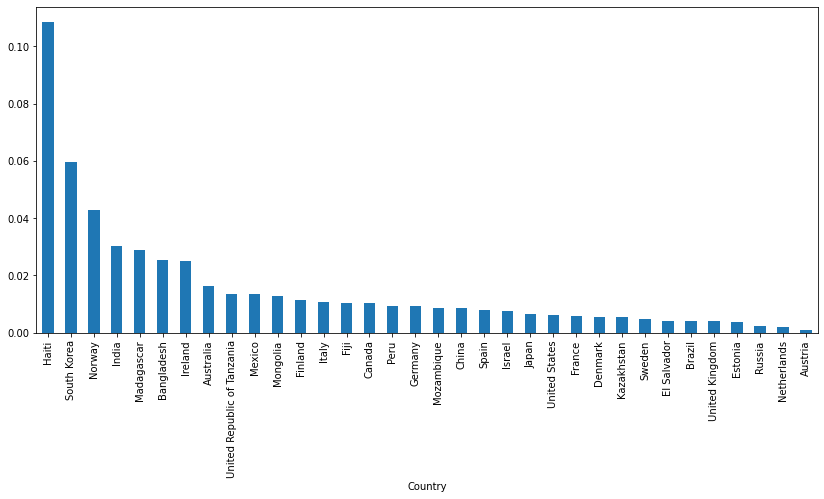

In [185]:
mcr_contagem[mcr_contagem["Genome"]>50]["average ARG per genome"].plot(kind="bar",figsize=(14,6))

In [186]:
# interpro=pd.read_table("interprout/mcr_ptn_interpro00",sep="\t",comment="#",header=None,engine='python')
# CDD=interpro[interpro[1]=="CDD"][8].str.split(";",expand=True)[[1,3,4]]
# CDD=pd.merge(interpro[[0,1,3,4,5,6]],CDD,left_index=True,right_index=True)
# CDD["3_y"]=CDD["3_y"].str.replace("signature_desc=","")
# CDD["4_y"]=CDD["4_y"].str.replace("Name=","")
# CDD.drop("1_y",axis=1,inplace=True)
# CDD.rename(columns={"3_y":"CDD_Name","4_y":"CDD ID"},inplace=True)

In [187]:
p=pd.read_csv("MAGs_MCR/fasta/mcr_contigs.fasta.probs.out",sep="\t",header=None)
p.columns=["contig_id","PlasClass_score"]

In [188]:
len(p[p["PlasClass_score"]>0.5])

346

In [189]:
len(p[p["PlasClass_score"]>0.7])

145

In [190]:
mcr2=pd.merge(mcr2,p,on="contig_id")

In [191]:
mcr2[mcr2["PlasClass_score"]>0.7]

,#ARG,query-start,query-end,ptn_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,genus,family,order,contig_length,label,plasmid,Plasflow_phyla,Plas_classification,id_phylogeny,PlasClass_score
33,MCR-3,8,529,GUT_GENOME014232_01554,peptide,ASF81896.1|FEATURES|MCR-3|peptide|MCR-3,0.996964,41.0,537,417.2,...,Ruminobacter_A,f__Succinivibrionaceae,o__Enterobacterales,7031,chromosome.unclassified,no,unclassified,chromosome,GUT_GENOME014232_01554|MCR-3|Ruminobacter_A|chromosome,0.778540
37,MCR-5,81,543,GUT_GENOME119225_01449,peptide,ATU90148.1|FEATURES|MCR-5|peptide|MCR-5,0.992549,38.4,476,327.8,...,Dakarella,f__Burkholderiaceae,o__Burkholderiales,3365,unclassified.unclassified,no,unclassified,unclassified,GUT_GENOME119225_01449|MCR-5|Dakarella|unclassified,0.761557
141,MCR-3,1,538,GUT_GENOME148296_03668,peptide,ASF81896.1|FEATURES|MCR-3|peptide|MCR-3,0.997801,61.9,538,723.0,...,Enterobacter,f__Enterobacteriaceae,o__Enterobacterales,5979,plasmid.Proteobacteria,yes,Proteobacteria,plasmid,GUT_GENOME148296_03668|MCR-3|Enterobacter|plasmid,0.986455
146,MCR-3,1,541,GUT_GENOME144057_04882,peptide,ASF81896.1|FEATURES|MCR-3|peptide|MCR-3,0.997708,99.4,541,1085.5,...,Escherichia,f__Enterobacteriaceae,o__Enterobacterales,2450,plasmid.Proteobacteria,yes,Proteobacteria,plasmid,GUT_GENOME144057_04882|MCR-3|Escherichia|plasmid,0.778529
149,MCR-3,7,524,GUT_GENOME147445_01951,peptide,ASF81896.1|FEATURES|MCR-3|peptide|MCR-3,0.996860,50.5,525,522.3,...,Vibrio,f__Vibrionaceae,o__Enterobacterales,76466,chromosome.Proteobacteria,no,Proteobacteria,chromosome,GUT_GENOME147445_01951|MCR-3|Vibrio|chromosome,0.996231
165,MCR-5,18,543,GUT_GENOME095248_01378,peptide,ATU90148.1|FEATURES|MCR-5|peptide|MCR-5,0.997735,47.3,537,485.7,...,Acidovorax_D,f__Burkholderiaceae,o__Burkholderiales,27279,plasmid.Proteobacteria,yes,Proteobacteria,plasmid,GUT_GENOME095248_01378|MCR-5|Acidovorax_D|plasmid,0.814380
167,MCR-5,14,541,GUT_GENOME095248_00172,peptide,ATU90148.1|FEATURES|MCR-5|peptide|MCR-5,0.997657,46.1,534,465.7,...,Acidovorax_D,f__Burkholderiaceae,o__Burkholderiales,89385,unclassified.Proteobacteria,no,Proteobacteria,unclassified,GUT_GENOME095248_00172|MCR-5|Acidovorax_D|unclassified,0.999060
178,MCR-3,1,539,GUT_GENOME147136_04018,peptide,ASF81896.1|FEATURES|MCR-3|peptide|MCR-3,0.997601,95.7,539,1047.7,...,Aeromonas,f__Aeromonadaceae,o__Enterobacterales,7074,plasmid.Proteobacteria,yes,Proteobacteria,plasmid,GUT_GENOME147136_04018|MCR-3|Aeromonas|plasmid,0.990779
180,MCR-5,47,537,GUT_GENOME216003_01816,peptide,ATU90148.1|FEATURES|MCR-5|peptide|MCR-5,0.986920,38.6,498,300.8,...,Sutterella,f__Burkholderiaceae,o__Burkholderiales,4765,unclassified.unclassified,no,unclassified,unclassified,GUT_GENOME216003_01816|MCR-5|Sutterella|unclassified,0.797865
186,MCR-3,12,538,GUT_GENOME221010_01658,peptide,ASF81896.1|FEATURES|MCR-3|peptide|MCR-3,0.997130,43.2,533,469.9,...,Succinivibrio,f__Succinivibrionaceae,o__Enterobacterales,1968,plasmid.Proteobacteria,yes,Proteobacteria,plasmid,GUT_GENOME221010_01658|MCR-3|Succinivibrio|plasmid,0.750314


In [192]:
samples=mcr2["Sample_accession"].drop_duplicates().to_list()

In [193]:
!mkdir -p sample_attibutes

In [194]:
# for g in samples:
#     link="https://www.ncbi.nlm.nih.gov/biosample/?term=" + str(g) + "&report=full&format=text"
#     wget.download(link,"sample_attibutes/"+str(g))

In [195]:
disease=pd.read_csv("disease.tsv",sep="/",header=None)
disease.columns=["Sample_accession","disease_status"]
disease["disease_status"]=disease["disease_status"].str.replace("host disease status=","").str.replace("host disease=","").str.replace("\"","")
disease=disease[~disease["disease_status"].str.contains("missing")]
disease=disease[~disease["disease_status"].str.contains("Missing")]
disease["disease_status"]=disease["disease_status"].str.replace("host health state=","").str.replace("Diagnosis=","")
disease["Sample_accession"]=disease["Sample_accession"].str.replace(":","")

In [196]:
disease["Sample_accession"]=disease["Sample_accession"].str.replace(" ","")

In [198]:
mcr2=pd.merge(mcr2,disease,on="Sample_accession",how="left")

In [201]:
mcr2.groupby("disease_status")[["#ARG"]].count()

,#ARG
disease_status,
Abdominal pain,1
Bloody diarrhea,1
Cancer,15
Cholera,3
Crohn's Disease,1
Diarrhea,5
Diarrhoea,3
Dysentery with Shigella dysenteriae co-infection,1
E.coli intestinal infection,1


In [205]:
mcr_prevalence=mcr2[mcr2["Plas_classification"]=="plasmid"].groupby(["genus","#ARG"])["#ARG"].count()
mcr_prevalence=pd.DataFrame(mcr_prevalence)
mcr_prevalence.columns=["Number of contigs"]
mcr_prevalence.reset_index(inplace=True)
mcr_prevalence.columns=["Number of #ARGs","plasmid","Number of contigs"]
mcr_prevalence=mcr_prevalence.set_index("Number of #ARGs").pivot(columns="plasmid",values="Number of contigs").fillna("0").reset_index()
mcr_prevalence.index.name = None
mcr_prevalence.columns.names = [None]
mcr_prevalence.set_index("Number of #ARGs",inplace=True)
mcr_prevalence=mcr_prevalence.astype(int)
mcr_prevalence.sort_values("MCR-5",ascending=False,inplace=True)

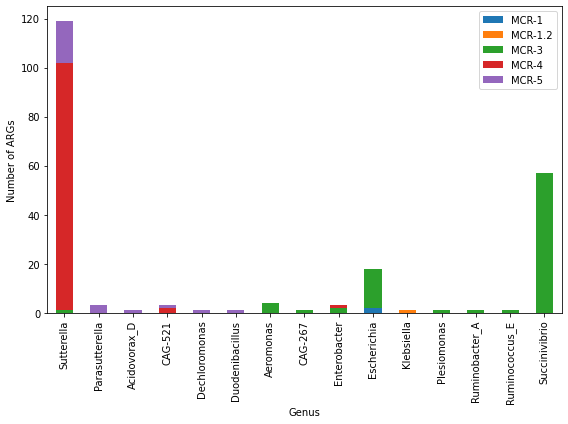

In [237]:
mcr_prevalence.plot(kind="bar",stacked=True,figsize=(8,6))
plt.ylabel("Number of ARGs")
plt.xlabel("Genus")
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

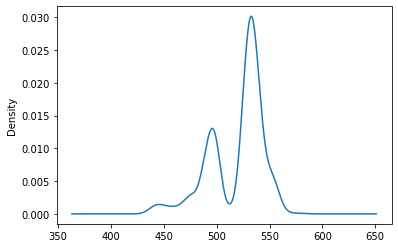

In [210]:
mcr2["alignment-length"].plot(kind="kde")

In [212]:
arg[arg["#ARG"].str.contains("NDM")]

#KPC, NDM, VIM, OXA-48-like

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
204177,NDM,1,270,GUT_GENOME145856_02119,beta-lactam,JX262694.1.gene1.p01|FEATURES|NDM-7|beta-lactam|NDM,0.999880,100.0,270,542.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae,Canada,North America,573.7221,SAMN04168653,PRJNA298912,GUT_GENOME147598,MGYG-HGUT-02538,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02538/genomes2/GUT_GENOME145856.gff.gz
252395,NDM,1,270,GUT_GENOME143868_03481,beta-lactam,JN104597.1.gene1.p01|FEATURES|NDM-5|beta-lactam|NDM,0.999880,100.0,270,543.1,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli_D,China,Asia,562.13723,SAMN05928999,PRJNA349231,GUT_GENOME144544,MGYG-HGUT-02506,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02506/genomes13/GUT_GENOME143868.gff.gz
322364,NDM,1,270,GUT_GENOME143388_04712,beta-lactam,JX262694.1.gene1.p01|FEATURES|NDM-7|beta-lactam|NDM,0.999880,100.0,270,542.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Salmonella;s__Salmonella enterica,India,Asia,28901.3648,SAMN08455839,PRJNA432628,GUT_GENOME142031,MGYG-HGUT-02366,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-023/MGYG-HGUT-02366/genomes1/GUT_GENOME143388.gff.gz
391941,NDM,1,270,GUT_GENOME144571_05102,beta-lactam,JX262694.1.gene1.p01|FEATURES|NDM-7|beta-lactam|NDM,0.999880,100.0,270,542.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli_D,Sweden,Europe,562.30349,SAMN07602583,PRJNA401330,GUT_GENOME144544,MGYG-HGUT-02506,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02506/genomes4/GUT_GENOME144571.gff.gz
583226,NDM,1,270,GUT_GENOME144955_05100,beta-lactam,CAZ39946.1|FEATURES|NDM-1|beta-lactam|NDM,0.999880,100.0,270,543.1,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli_D,NaN,NaN,562.33455,SAMN09710898,PRJNA482002,GUT_GENOME144544,MGYG-HGUT-02506,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02506/genomes10/GUT_GENOME144955.gff.gz
894656,NDM,1,270,GUT_GENOME144835_00453,beta-lactam,AGU91756.1|FEATURES|NDM-9|beta-lactam|NDM,0.999894,100.0,270,543.1,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli_D,China,Asia,562.30821,SAMN07556509,PRJNA400107,GUT_GENOME144544,MGYG-HGUT-02506,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02506/genomes12/GUT_GENOME144835.gff.gz
1396384,NDM,1,270,GUT_GENOME145855_04345,beta-lactam,JX262694.1.gene1.p01|FEATURES|NDM-7|beta-lactam|NDM,0.999880,100.0,270,542.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae,Canada,North America,573.7218,SAMN04168650,PRJNA298912,GUT_GENOME147598,MGYG-HGUT-02538,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02538/genomes1/GUT_GENOME145855.gff.gz
1673485,NDM,1,270,GUT_GENOME145431_04325,beta-lactam,JX262694.1.gene1.p01|FEATURES|NDM-7|beta-lactam|NDM,0.999880,100.0,270,542.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobactera

In [214]:
arg[arg["#ARG"].str.contains("VIM")]


,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download


In [215]:
arg[arg["#ARG"].str.contains("OXA")]


,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
9629,OXA,18,253,GUT_GENOME040895_00750,beta-lactam,AY227054.1.gene1.p01|FEATURES|OXA-85|beta-lactam|OXA,0.999830,57.6,236,293.1,...,NaN,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium;s__Phascolarctobacterium sp000436095,United States,North America,ERZ929604,ERS1066711,ERP013933,GUT_GENOME268399,MGYG-HGUT-04337,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-043/MGYG-HGUT-04337/genomes1/GUT_GENOME040895.gff.gz
13815,OXA,25,254,GUT_GENOME140121_00419,beta-lactam,AY227054.1.gene1.p01|FEATURES|OXA-85|beta-lactam|OXA,1.000000,34.6,243,120.6,...,NaN,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Peptostreptococcales;f__Peptostreptococcaceae;g__Clostridioides;s__Clostridioides difficile,United States,North America,NaN,SRS1529687,SRP077514,GUT_GENOME142330,MGYG-HGUT-02369,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-023/MGYG-HGUT-02369/genomes1/GUT_GENOME140121.gff.gz
14747,OXA,1,264,GUT_GENOME147138_04483,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,93.9,264,514.6,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Aeromonas;s__Aeromonas hydrophila,United States,North America,644.65,SAMN03294822,PRJNA273636,GUT_GENOME147138,MGYG-HGUT-02526,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02526/genomes1/GUT_GENOME147138.gff.gz
19290,OXA,35,259,GUT_GENOME095736_03240,beta-lactam,HM015773.1.gene6.p01|FEATURES|OXA-162|beta-lactam|OXA,0.999996,43.8,226,198.7,...,NaN,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Bradyrhizobium;s__Bradyrhizobium sp000015165,Italy,Europe,NaN,NaN,NaN,GUT_GENOME207869,MGYG-HGUT-03137,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-031/MGYG-HGUT-03137/genomes1/GUT_GENOME095736.gff.gz
21324,OXA,6,273,GUT_GENOME223051_00181,beta-lactam,JF268688.1.gene5.p01|FEATURES|OXA-209|beta-lactam|OXA,0.999905,35.1,276,159.1,...,NaN,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides uniformis,Finland,Europe,NaN,SRS1719193,SRP090628,GUT_GENOME096083,MGYG-HGUT-01346,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-013/MGYG-HGUT-01346/genomes12/GUT_GENOME223051.gff.gz
23364,OXA,17,259,GUT_GENOME123521_02148,beta-lactam,JF273470.1.gene1.p01|FEATURES|OXA-192|beta-lactam|OXA,1.000000,30.9,275,107.5,...,NaN,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Selenomonadales;f__Selenomonadaceae;g__Megamonas;s__Megamonas funiformis,China,Asia,NaN,ERS1138869,ERP015450,GUT_GENOME140251,MGYG-HGUT-02284,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-022/MGYG-HGUT-02284/genomes2/GUT_GENOME123521.gff.gz
24243,OXA,56,263,GUT_GENOME036207_01852,beta-lactam,EF552405.1.gene1.p01|FEATURES|OXA-141|beta-lactam|OXA,0.998815,33.5,221,113.6,...,NaN,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis vadensis,China,Asia,ERZ871474,ERS1015960,ERP013563,GUT_GENOME143495,MGYG-HGUT-02473,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-024/MGYG-HGUT-02473/genomes1/GUT_GENOME036207.gff.gz
24576,OXA,1,264,GUT_GENOME147137_04614,beta-lactam,U10251.1.gene1.p01|FEATURES|OXA-12|beta-lactam|OXA,1.000000,93.2,264,512.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Aeromonadaceae;g__Ae

In [213]:
arg[arg["#ARG"].str.contains("KPC")]


,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
135673,KPC,1,293,GUT_GENOME145599_05119,beta-lactam,AY034847.1.gene1.p01|FEATURES|KPC-2|beta-lactam|KPC,0.985638,100.0,293,581.6,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae,China,Asia,573.14872,SAMN07251852,PRJNA390758,GUT_GENOME147598,MGYG-HGUT-02538,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02538/genomes1/GUT_GENOME145599.gff.gz
353231,KPC,1,293,GUT_GENOME143753_04289,beta-lactam,AF395881.gene.p01|FEATURES|KPC-3|beta-lactam|KPC,0.985638,99.0,295,574.7,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Enterobacter;s__Enterobacter himalayensis,United States,North America,550.1655,SAMN09694008,PRJNA482007,GUT_GENOME143760,MGYG-HGUT-02504,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02504/genomes1/GUT_GENOME143753.gff.gz
488277,KPC,1,293,GUT_GENOME141399_04485,beta-lactam,ACA34343|FEATURES|KPC-4|beta-lactam|KPC,0.985638,100.0,293,581.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Enterobacter;s__Enterobacter himalayensis,United States,North America,1329836.3,SAMN02138600,PRJNA201975,GUT_GENOME143760,MGYG-HGUT-02504,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02504/genomes1/GUT_GENOME141399.gff.gz
992521,KPC,1,293,GUT_GENOME145665_05186,beta-lactam,AY034847.1.gene1.p01|FEATURES|KPC-2|beta-lactam|KPC,0.985638,98.6,293,568.5,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae,Brazil,South America,573.15013,SAMN07572878,PRJNA400691,GUT_GENOME147598,MGYG-HGUT-02538,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02538/genomes2/GUT_GENOME145665.gff.gz
1527958,KPC,1,293,GUT_GENOME147566_05168,beta-lactam,AF395881.gene.p01|FEATURES|KPC-3|beta-lactam|KPC,0.976798,100.0,293,581.3,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae,NaN,NaN,72407.1106,SAMN08399030,PRJNA431724,GUT_GENOME147598,MGYG-HGUT-02538,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02538/genomes2/GUT_GENOME147566.gff.gz
1795381,KPC,1,293,GUT_GENOME145802_05192,beta-lactam,AF395881.gene.p01|FEATURES|KPC-3|beta-lactam|KPC,0.985638,99.7,293,577.8,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae,United States,North America,573.19932,SAMN09694009,PRJNA482007,GUT_GENOME147598,MGYG-HGUT-02538,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-025/MGYG-HGUT-02538/genomes2/GUT_GENOME145802.gff.gz


In [222]:
args_in_genome_with_mcr.head()

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
2065,DFRA1,17,182,GUT_GENOME010511_01163,diaminopyrimidine,CAL48457|FEATURES|dfrA1|diaminopyrimidine|dfrA1,0.999999,40.4,166,138.3,...,antibiotic target replacement,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2066,PBP-1A,2,801,GUT_GENOME010511_00690,beta-lactam,YP_001290033|FEATURES|PBP-1A|beta-lactam|PBP-1A,0.999495,34.5,826,466.1,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2067,ROSB,1,515,GUT_GENOME010511_01646,fosmidomycin,gi:1001786599:ref:WP_061324791.1:|FEATURES|rosB|fosmidomycin|rosB,0.994635,47.3,531,401.0,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2068,MACA,17,323,GUT_GENOME010511_00128,MLS,gi:364569463:gb:EHM47085.1:|FEATURES|macA|MLS|macA,0.997967,31.9,313,92.8,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2069,TRANSCRIPTIONAL_REGULATORY_PROTEIN_CPXR_CPXR,5,222,GUT_GENOME010511_00130,unclassified,CP000675.2.gene1535.p01|FEATURES|transcriptional_regulatory_protein_CpxR_cpxR|unclassified|transcriptional_regulatory_protein_CpxR_cpxR,0.875877,39.4,218,144.8,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz


In [232]:
classes_in_genome_with_mcr=args_in_genome_with_mcr[~args_in_genome_with_mcr["#ARG"].str.contains("MCR-")].groupby("predicted_ARG-class")[["#ARG"]].count()

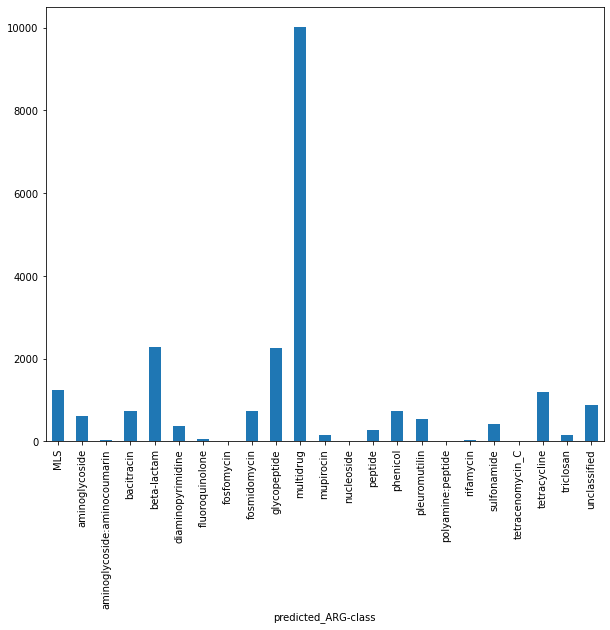

In [261]:
classes_in_genome_with_mcr["#ARG"].plot(kind="bar",figsize=(10,8))

In [240]:
classes_in_genome_with_mcr

,#ARG
predicted_ARG-class,
MLS,1234
aminoglycoside,619
aminoglycoside:aminocoumarin,27
bacitracin,735
beta-lactam,2271
diaminopyrimidine,365
fluoroquinolone,69
fosfomycin,5
fosmidomycin,740


In [224]:
len(args_in_genome_with_mcr)

24825

In [256]:
betalact=args_in_genome_with_mcr[(args_in_genome_with_mcr["predicted_ARG-class"]=="beta-lactam")].groupby("#ARG")[["read_id"]].count()

In [258]:
betalact.columns=["Beta-lactam"]

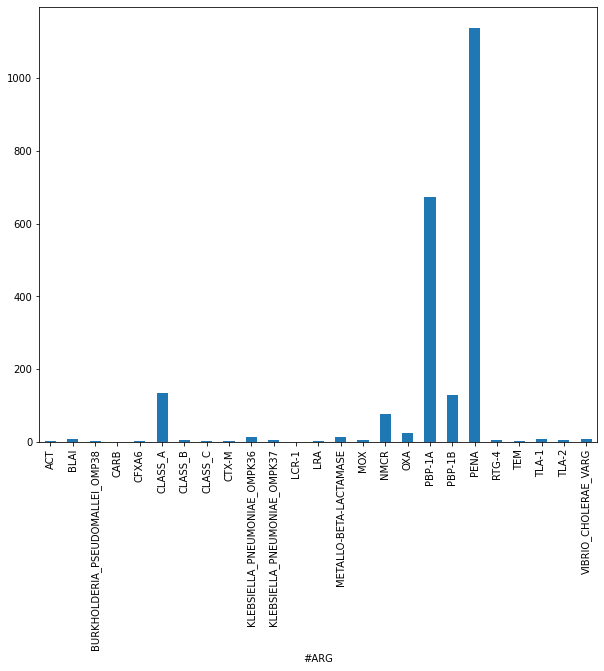

In [263]:
betalact.plot(kind="bar",figsize=(10,8),legend=None)

In [300]:
#args_in_genome_with_mcr.groupby("#ARG").count()

In [299]:
#mcr2.sort_values("identity")

In [298]:
#mcr2.sort_values("identity")

In [248]:
mcr2.columns

Index(['#ARG', 'query-start', 'query-end', 'ptn_id', 'predicted_ARG-class',
       'best-hit', 'probability', 'identity', 'alignment-length',
       'alignment-bitscore', 'alignment-evalue', 'counts', 'Genome',
       'AMR Gene Family', 'Protein Accession', 'Drug Class',
       'Resistance Mechanism', 'Lineage', 'Country', 'Continent',
       'Genome_accession', 'Sample_accession', 'Study_accession',
       'Species_rep', 'MGnify_accession', 'FTP_download', 'contig_id',
       'ptn_start', 'ptn_stop', 'ptn_strand', 'gff_features', 'species',
       'genus', 'family', 'order', 'contig_length', 'label', 'plasmid',
       'Plasflow_phyla', 'Plas_classification', 'id_phylogeny',
       'PlasClass_score', 'disease_status'],
      dtype='object')

In [290]:
#mcr2.sort_values("identity")["contig_id"]

In [289]:
#mcr2["Sample_accession"]

In [266]:
mcr2[mcr2["#ARG"]=="MCR-2"]["Country"]

8              Canada
64                NaN
390            Canada
586               NaN
1285             Fiji
1356           Sweden
1904          Finland
1997            China
2019    United States
Name: Country, dtype: object

In [288]:
#mcr2[mcr2["#ARG"]=="MCR-1"]

In [291]:
#mcr2[mcr2["Genome"]=="GUT_GENOME144057"][['#ARG', 'query-start', 'query-end', 'ptn_id',"contig_id",'ptn_start', 'ptn_stop','Country','Study_accession']]

In [292]:
#mcr2[mcr2["Genome"]=="GUT_GENOME144798"][['#ARG', 'query-start', 'query-end', 'ptn_id',"contig_id",'ptn_start', 'ptn_stop','Country','Study_accession']]

In [293]:
#mcr2.columns

In [294]:
#mcr2[mcr2["#ARG"]=="MCR-5"]

In [287]:
mcr2[mcr2["Genome"]=="GUT_GENOME147136"]["contig_id"]

177     GUT_GENOME147136_23
178    GUT_GENOME147136_105
Name: contig_id, dtype: object

In [296]:
args_in_genome_with_mcr.head()

,#ARG,query-start,query-end,read_id,predicted_ARG-class,best-hit,probability,identity,alignment-length,alignment-bitscore,...,Resistance Mechanism,Lineage,Country,Continent,Genome_accession,Sample_accession,Study_accession,Species_rep,MGnify_accession,FTP_download
2065,DFRA1,17,182,GUT_GENOME010511_01163,diaminopyrimidine,CAL48457|FEATURES|dfrA1|diaminopyrimidine|dfrA1,0.999999,40.4,166,138.3,...,antibiotic target replacement,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2066,PBP-1A,2,801,GUT_GENOME010511_00690,beta-lactam,YP_001290033|FEATURES|PBP-1A|beta-lactam|PBP-1A,0.999495,34.5,826,466.1,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2067,ROSB,1,515,GUT_GENOME010511_01646,fosmidomycin,gi:1001786599:ref:WP_061324791.1:|FEATURES|rosB|fosmidomycin|rosB,0.994635,47.3,531,401.0,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2068,MACA,17,323,GUT_GENOME010511_00128,MLS,gi:364569463:gb:EHM47085.1:|FEATURES|macA|MLS|macA,0.997967,31.9,313,92.8,...,antibiotic efflux,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz
2069,TRANSCRIPTIONAL_REGULATORY_PROTEIN_CPXR_CPXR,5,222,GUT_GENOME010511_00130,unclassified,CP000675.2.gene1535.p01|FEATURES|transcriptional_regulatory_protein_CpxR_cpxR|unclassified|transcriptional_regulatory_protein_CpxR_cpxR,0.875877,39.4,218,144.8,...,NaN,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Sutterella;s__,Sweden,Europe,NaN,ERS554254,ERP007090,GUT_GENOME128042,MGYG-HGUT-02101,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/2019_09/all_genomes/MGYG-HGUT-021/MGYG-HGUT-02101/genomes1/GUT_GENOME010511.gff.gz


In [297]:
args_in_genome_with_mcr.columns

Index(['#ARG', 'query-start', 'query-end', 'read_id', 'predicted_ARG-class',
       'best-hit', 'probability', 'identity', 'alignment-length',
       'alignment-bitscore', 'alignment-evalue', 'counts', 'Genome',
       'AMR Gene Family', 'Protein Accession', 'Drug Class',
       'Resistance Mechanism', 'Lineage', 'Country', 'Continent',
       'Genome_accession', 'Sample_accession', 'Study_accession',
       'Species_rep', 'MGnify_accession', 'FTP_download'],
      dtype='object')

In [302]:
mcr2.to_csv("mcr_dataframe.tsv",sep="\t",index=None)

In [303]:
args_in_genome_with_mcr.to_csv("mcr_with_otherARGs_dataframe.tsv",sep="\t",index=None)